# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import xgboost as xgb  # Import XGBoost library
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
# Sample data
data = pd.read_csv('Houseprice.csv')
data

,Date,Region ID,Region Name,Region Type,State Name,Home Value Index,Size Rank
0,7/31/03,395162,"Torrington, CT",msa,CT,206829.9543,236
1,8/31/03,395162,"Torrington, CT",msa,CT,209576.4668,236
2,9/30/03,395162,"Torrington, CT",msa,CT,212398.5270,236
3,10/31/03,395162,"Torrington, CT",msa,CT,215175.9703,236
4,11/30/03,395162,"Torrington, CT",msa,CT,217573.4558,236
...,...,...,...,...,...,...,...
255965,3/31/17,394776,"Laurel, MS",msa,MS,107746.9037,434
255966,3/31/17,395124,"Starkville, MS",msa,MS,169984.2309,529
255967,3/31/17,394490,"Columbus, MS",msa,MS,125443.1976,543
255968,3/31/17,394977,"Picayune, MS",msa,MS,150324.7686,559


# Loading and Preprocessing Data

In [2]:
data = data[data['Region Name'] == 'Salt Lake City, UT']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
df = pd.DataFrame(data)
df = df[['Date', 'Home Value Index']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Home Value Index
Date,
2000-01-31,173370.8057
2000-02-29,173473.7350
2000-03-31,173659.8637
2000-04-30,174086.9221
2000-05-31,175910.0283
...,...
2023-06-30,524735.4525
2023-07-31,526616.8991
2023-08-31,528841.3976


# Data Normalization and Train-Test Split

In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Splitting data into training and testing
train_size = int(len(scaled_data) * 0.9)
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [4]:
# Convert array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Creating XGBoost Model


In [5]:
# XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Train the XGBoost model
xgb_model.fit(X_train, Y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

# Making Predictions and Evaluating the Model


In [6]:
# Make predictions
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate root mean squared error
train_rmse = np.sqrt(mean_squared_error(train_predict[:, 0], Y_train_inv[0]))
test_rmse = np.sqrt(mean_squared_error(test_predict[:, 0], Y_test_inv[0]))

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 44813.24002608479
Test RMSE: 254029.00520649433


# Visualizing Training Results


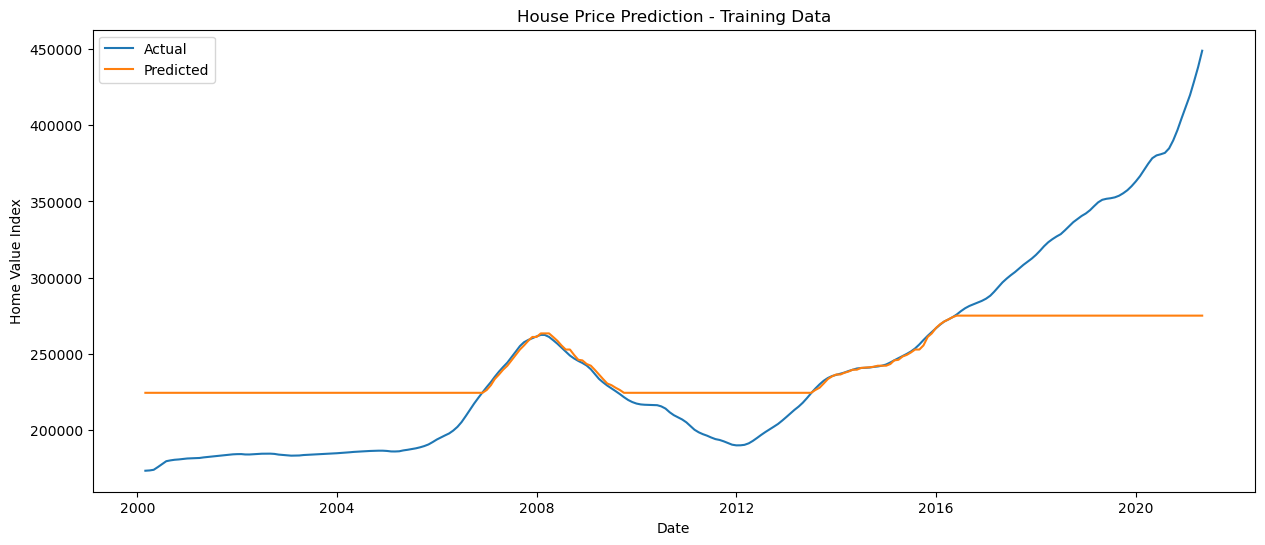

In [7]:
# Plotting Train Data
plt.figure(figsize=(15, 6))
plt.plot(df.index[look_back:train_size-1], Y_train_inv[0], label='Actual')
plt.plot(df.index[look_back:train_size-1], train_predict[:, 0], label='Predicted')
plt.title('House Price Prediction - Training Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Visualizing Testing Results


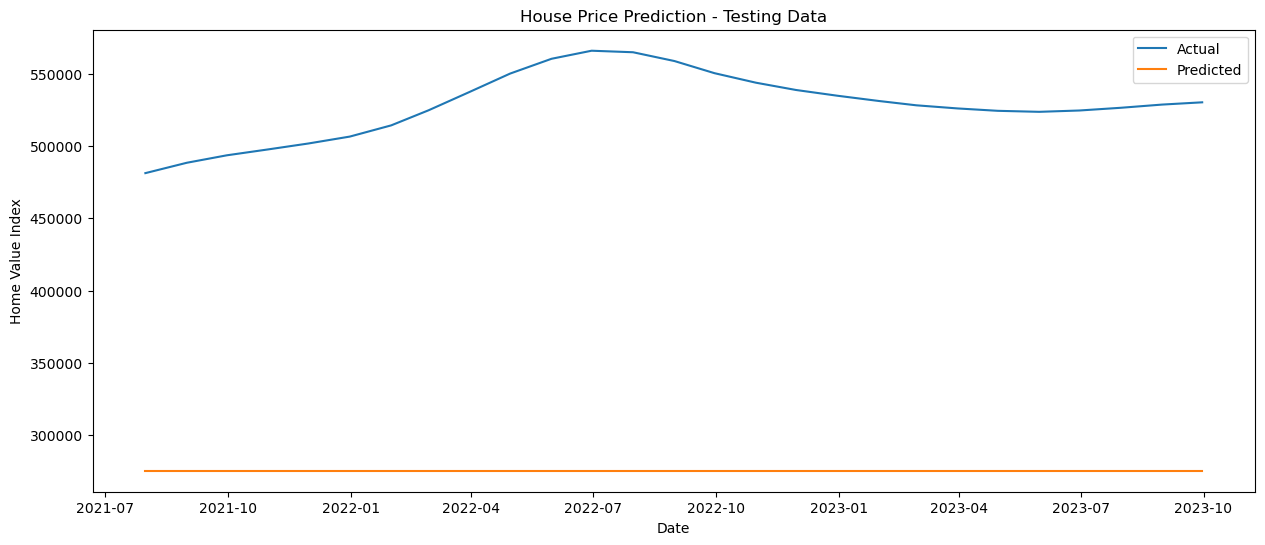

In [8]:
# Plotting Test Data
plt.figure(figsize=(15, 6))
plt.plot(df.index[train_size + look_back : -1], Y_test_inv[0], label='Actual')
plt.plot(df.index[train_size + look_back : -1], test_predict[:, 0], label='Predicted')
plt.title('House Price Prediction - Testing Data')
plt.xlabel('Date')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()

# Generating Future Predictions

In [9]:
# Future predictions with XGBoost
future_months = 24
future_predictions = []

# Start with the last known data
current_input = scaled_data[-look_back:].reshape((1, look_back))

for _ in range(future_months):
    # Predict the next step and reshape input for the model
    next_prediction = xgb_model.predict(current_input)
    
    # Append the prediction
    future_predictions.append(next_prediction[0])
    
    # Update the input sequence
    current_input = np.array([next_prediction[0]])

# Inverse transform to get actual value predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Adjust the date generation to reflect monthly steps
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date, periods=future_months, freq='MS')
future_df = pd.DataFrame(future_predictions, index=prediction_dates, columns=['Predicted Future Value'])
future_df

,Predicted Future Value
2023-11-01,275164.03125
2023-12-01,275164.03125
2024-01-01,275164.03125
2024-02-01,275164.03125
2024-03-01,275164.03125
2024-04-01,275164.03125
2024-05-01,275164.03125
2024-06-01,275164.03125
2024-07-01,275164.03125
2024-08-01,275164.03125


# Visualizing Test Data and Future Predictions


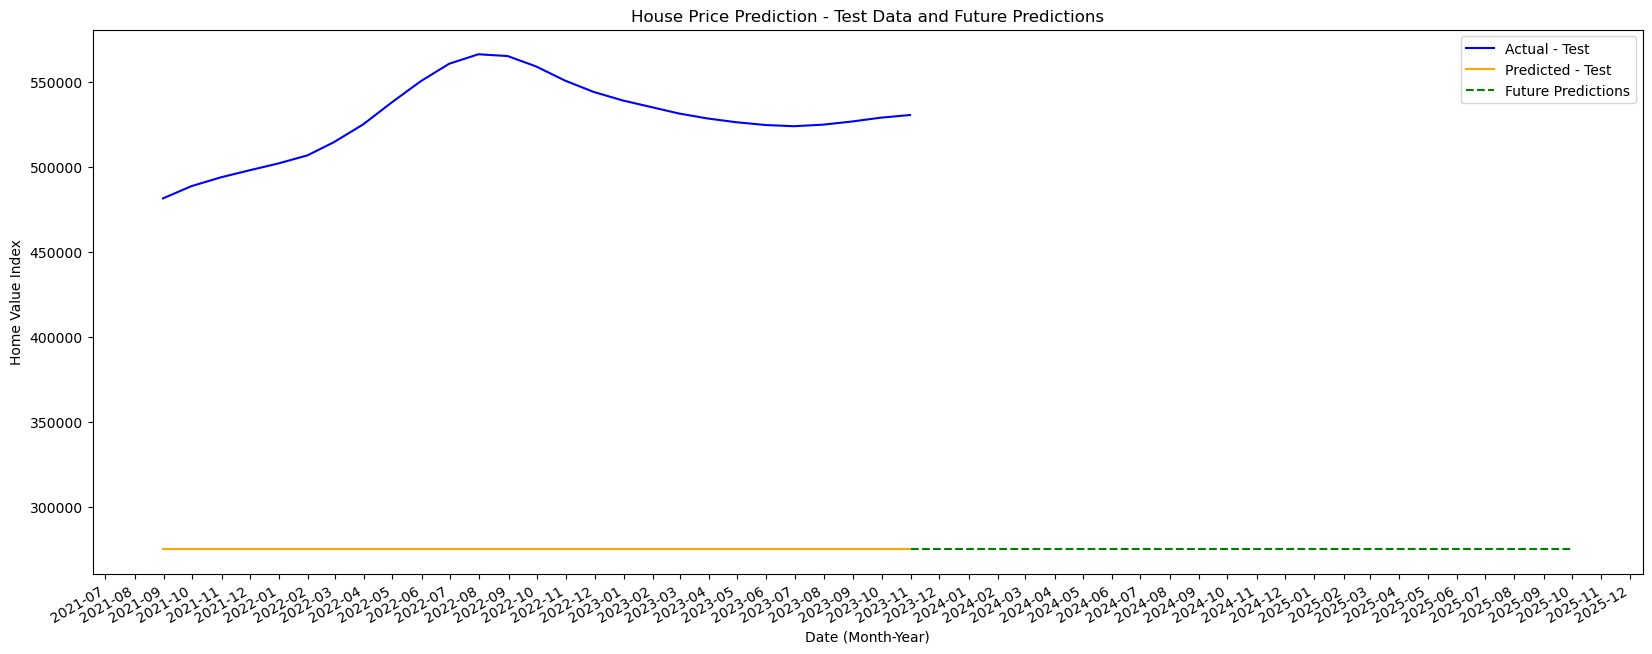

In [10]:
#  Plotting Future Predictions
plt.figure(figsize=(20, 8))

# Plot actual and predicted test data
plt.plot(df.index[-len(test_predict):], Y_test_inv[0], label='Actual - Test', color='blue')
plt.plot(df.index[-len(test_predict):], test_predict[:, 0], label='Predicted - Test', color='orange')

# Plot future predictions
plt.plot(future_df.index, future_df['Predicted Future Value'], label='Future Predictions', color='green', linestyle='dashed')

# Formatting the x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.title('House Price Prediction - Test Data and Future Predictions')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Home Value Index')
plt.legend()
plt.show()